# Bayesian attribution models

##### Libraries

In [121]:
# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy import stats

# Pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable

# Pyro
import pyro
from pyro.distributions import Normal
from pyro.infer import SVI
from pyro.optim import Adam

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
plt.style.use("ggplot")
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = (15,4)
plt.rcParams['grid.color'] = "#d4d4d4"
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['lines.linewidth'] = 2

# Simulating some data

## Generating fake data

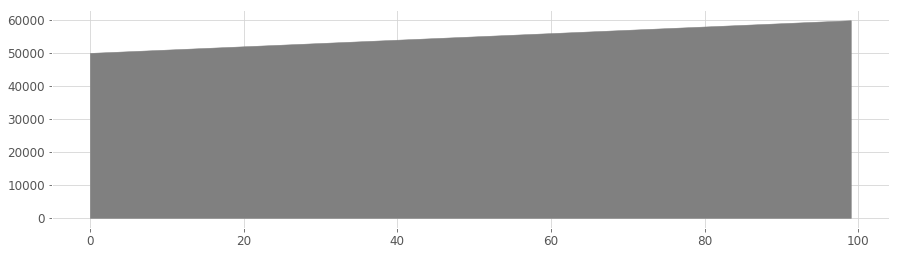

In [123]:
d = np.array(range(100))
base = 50000 + d * 100
plt.stackplot(d,base,color = "grey")
plt.show()

##### Distribution of the first lever : Promotion

In [124]:
support1 = np.linspace(0,14,100)

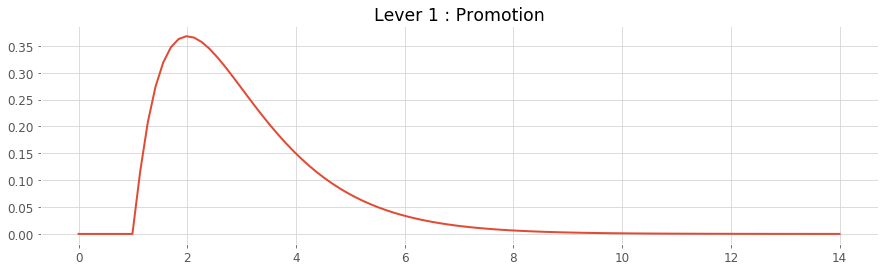

In [125]:
plt.title("Lever 1 : Promotion")
distrib_lever1 = stats.gamma.pdf(support1,2,1)
plt.plot(support1,distrib_lever1)
plt.show()

In [126]:
def generate_promotion(start_date,length,intensity,std_noise = 0,gamma = (2,1)):
    support = np.linspace(0,length,100)
    distribution = stats.gamma.pdf(support,*gamma)
    distribution = np.divide(distribution,np.max(distribution))
    lever = np.zeros(100)
    lever[start_date:start_date+length] = intensity * distribution[::int(100/length)][:length] + np.random.normal(0,std_noise,length)
    return lever

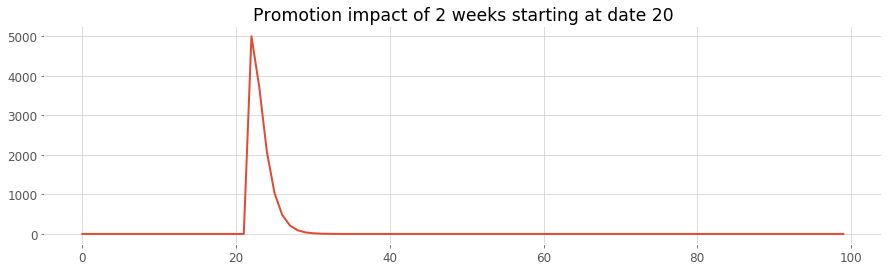

In [127]:
plt.title("Promotion impact of 2 weeks starting at date 20")
plt.plot(generate_promotion(20,14,5000))
plt.show()

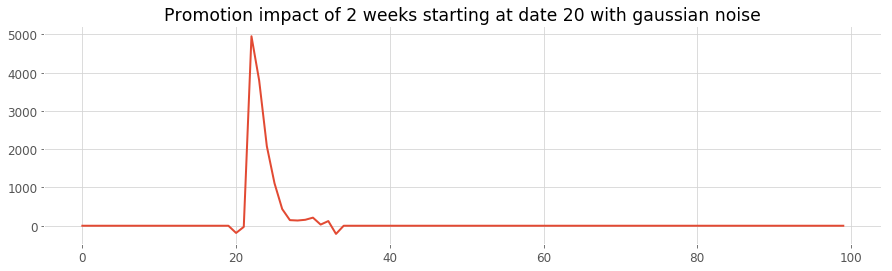

In [128]:
plt.title("Promotion impact of 2 weeks starting at date 20 with gaussian noise")
plt.plot(generate_promotion(20,14,5000,100))
plt.show()

##### Distribution of the second lever : Campaign

In [129]:
support2 = np.linspace(0,60,100)

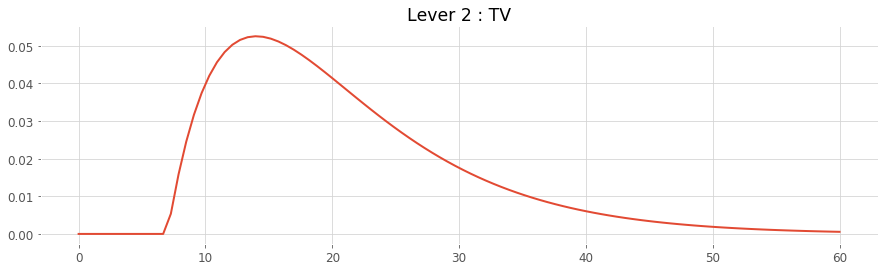

In [130]:
plt.title("Lever 2 : TV")
distrib_lever2 = stats.gamma.pdf(support2,2,7,7)
plt.plot(support2,distrib_lever2)
plt.show()

In [131]:
def generate_campaign(start_date,length,intensity,std_noise = 0,gamma = (2,3,7)):
    support = np.linspace(0,length,100)
    distribution = stats.gamma.pdf(support,*gamma)
    distribution = np.divide(distribution,np.max(distribution))
    lever = np.zeros(100)
    lever[start_date:start_date+length] = intensity * distribution[::int(100/length)][:length] + np.random.normal(0,std_noise,length)
    return lever

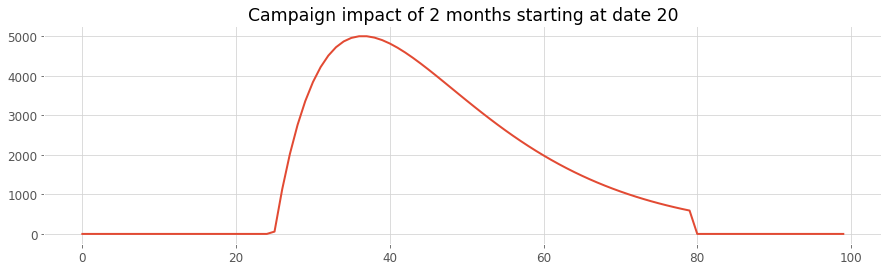

In [132]:
plt.title("Campaign impact of 2 months starting at date 20")
plt.plot(generate_campaign(20,60,5000))
plt.show()

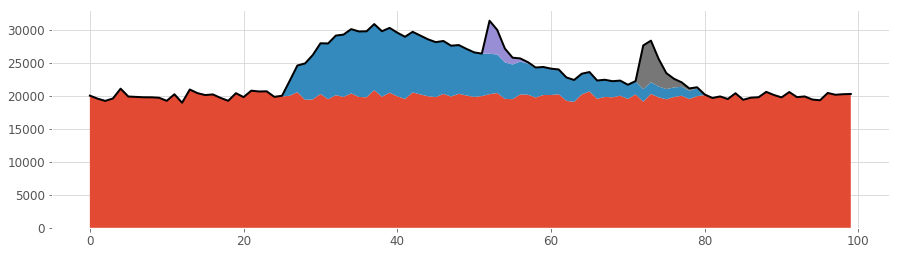

In [133]:
d = np.array(range(100))
base = 20000  + np.random.normal(0,500,100) # d * 100
campaign1 = generate_campaign(20,60,10000)
promotion1 = generate_promotion(50,14,5000)
promotion2 = generate_promotion(70,21,7000)
sales = base + campaign1 + promotion1 + promotion2
plt.stackplot(d,[base,campaign1,promotion1,promotion2]) #,name = ["base","campaign1","promotion1"])
plt.plot(sales,color = "black")
plt.show()

## Reversing the generation

# Concept

## Testing the basic concept

In [134]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

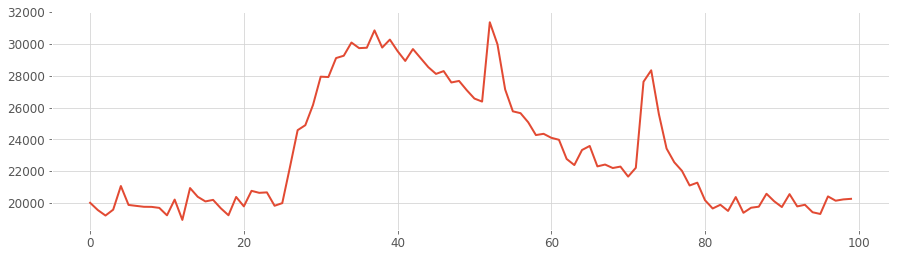

In [135]:
plt.plot(sales)
plt.show()

##### Generate placeholders

In [136]:
campaign1 = generate_campaign(20,60,1)
promotion1 = generate_promotion(50,14,1)
promotion2 = generate_promotion(70,21,1)

##### Prepare the data

In [137]:
data = np.vstack([campaign1,promotion1,promotion2]).T
data.shape

(100, 3)

##### Regression

In [138]:
lr = LinearRegression()
lr.fit(data,sales)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [139]:
lr.coef_

array([ 10066.70210442,   5190.17841643,   6637.62611154])

In [144]:
data.shape

(100, 3)

In [48]:
lr.intercept_

20039.504841268845

##### Performance

In [40]:
prediction = lr.predict(data)

In [42]:
r2_score(prediction,sales)

0.98186409536144392

##### Changing one coefficient

In [49]:
campaign1 = generate_campaign(20,40,1)
promotion1 = generate_promotion(50,14,1)
promotion2 = generate_promotion(70,21,1)

In [50]:
data = np.vstack([campaign1,promotion1,promotion2]).T
lr = LinearRegression()
lr.fit(data,sales)
prediction = lr.predict(data)
r2_score(prediction,sales)

0.7861828913253559

In [51]:
campaign1 = generate_campaign(20,60,1)
promotion1 = generate_promotion(40,14,1)
promotion2 = generate_promotion(70,21,1)
data = np.vstack([campaign1,promotion1,promotion2]).T
lr = LinearRegression()
lr.fit(data,sales)
prediction = lr.predict(data)
r2_score(prediction,sales)

0.94886510539005742

## Developing the concept

### Creating the variables

In [175]:
import dlm

In [82]:
c1 = dlm.Campaign([20,50])
c2 = dlm.Campaign([10,30])

In [83]:
c1

Campaign(start=20,length=50)

In [84]:
c1 + c2

Campaign(start=15,length=40)

In [91]:
c1.mutate(impact = 0.5)
c1

Campaign(start=28,length=43)

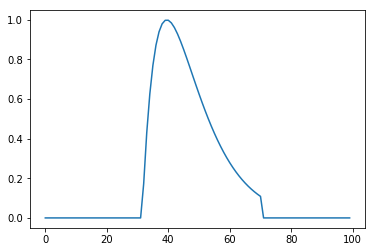

In [92]:
c1.plot()

In [93]:
dlm.Campaign()

Campaign(start=5,length=45)

### Creating the population

In [165]:
v1 = dlm.Variables()
v1.variables

[Campaign(start=73,length=7),
 Promotion(start=85,length=14),
 Promotion(start=13,length=30)]

In [166]:
v2 = dlm.Variables()
v2.variables

[Campaign(start=32,length=17),
 Promotion(start=59,length=35),
 Promotion(start=75,length=14)]

In [167]:
v3 = v1 + v2
v3.variables

[Campaign(start=52,length=12),
 Promotion(start=72,length=24),
 Promotion(start=44,length=22)]

In [168]:
v3.mutate()
v3.variables

[Campaign(start=52,length=12),
 Promotion(start=66,length=24),
 Promotion(start=44,length=21)]

In [169]:
v3.get_data().shape

(100, 3)

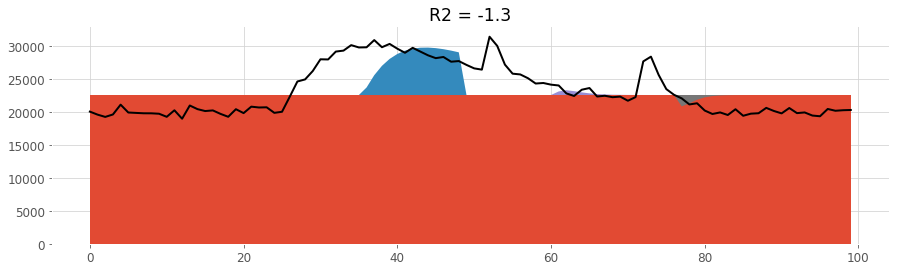

In [170]:
v2.plot(sales)

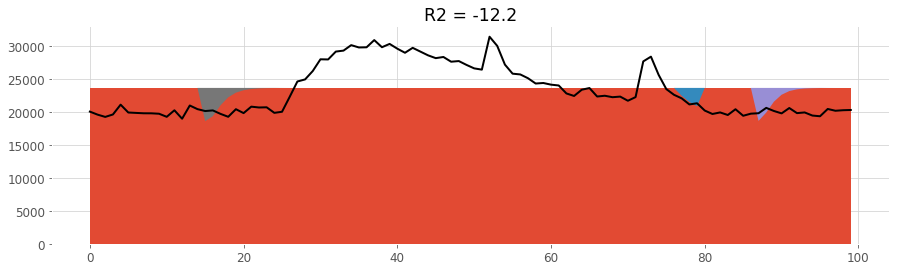

In [171]:
v1.plot(sales)

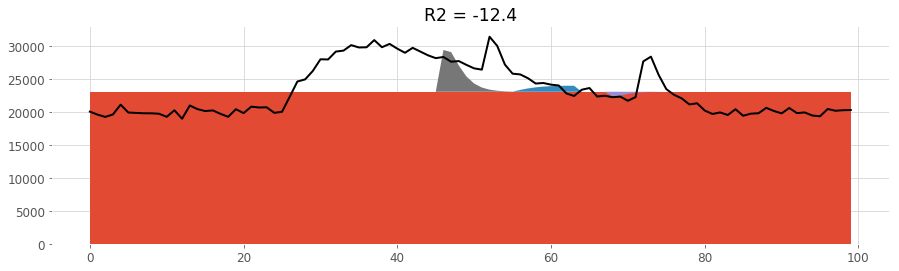

In [172]:
v3.plot(sales)

## Testing the training

In [226]:
pop = dlm.Population()

In [227]:
len(pop)

50

- Generations 50
- Fittest : 12
- Offsprings : 66


100%|██████████████████████████████████████████| 50/50 [00:06<00:00,  7.20it/s]


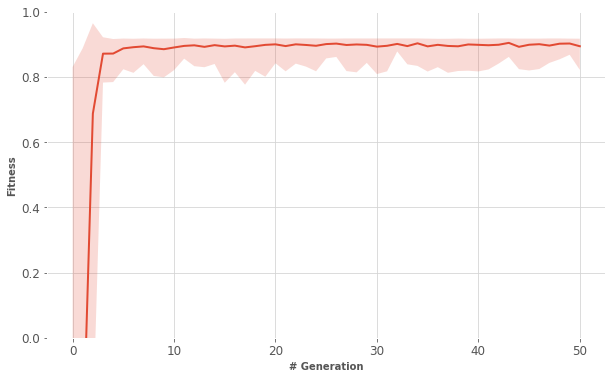

In [228]:
new_pop = pop.evolve(sales,n_generations=50)

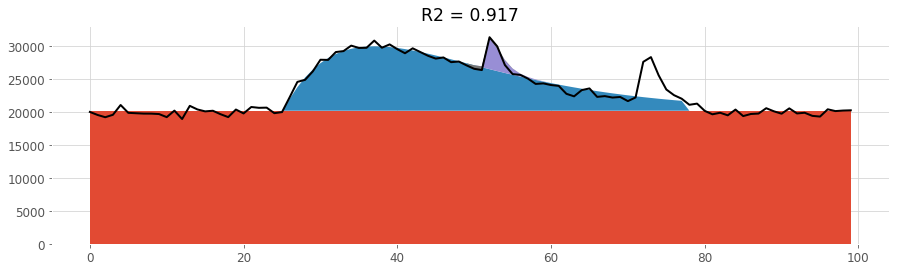

In [229]:
new_pop[0].plot(sales)

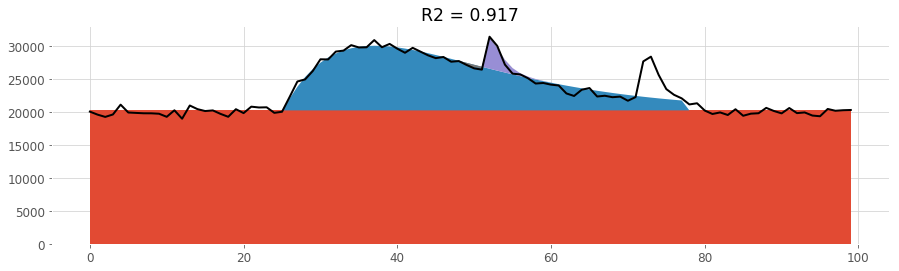

In [230]:
new_pop[2].plot(sales)